## Work done by: Mohammad Al-Refaie 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway, stats
import statsmodels.stats.multicomp as mc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Performing some Analysis.

In [2]:
df = pd.read_csv(r"C:\Users\mohdh\Desktop\TTU\ShAI Course\Projects\Project 2\project_2_data.csv")

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 81)

In [5]:
counts = df['GarageFinish'].unique()
counts

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [6]:
df_cleaned = df[['GarageFinish', 'SalePrice']].dropna()

In [7]:
min_sale = df_cleaned['SalePrice'].min()
min_sale

35311

In [8]:
max_sale = df_cleaned['SalePrice'].max()
max_sale

755000

In [9]:
avg_sale = df_cleaned['SalePrice'].mean()
avg_sale

185479.511240029

C:\Users\mohdh\AppData\Local\Temp\ipykernel_7008\1921187904.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='SalePrice', ylabel='Density'>

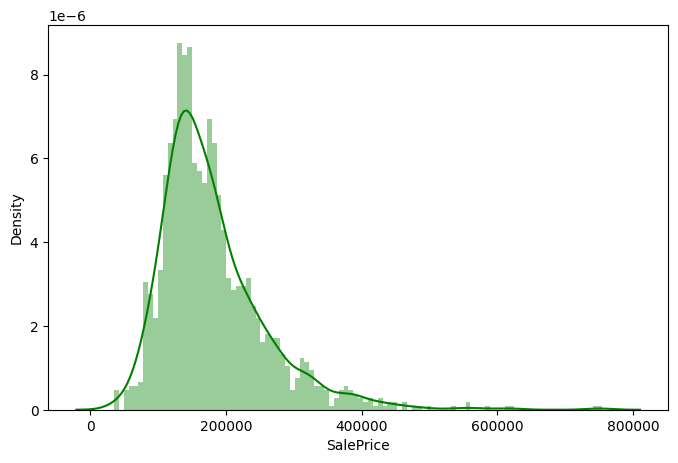

In [10]:
plt.figure(figsize=(8, 5))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

**The data is right skewed.**

#### 1- we need to Ensure that each group has a sufficient number of observations.

In [11]:
group_counts = df_cleaned['GarageFinish'].value_counts()
total_counts = group_counts.sum()
category_proportions = group_counts / total_counts
print(f"Counts for each category: {group_counts}")
print(f"\nProportions for each category: {category_proportions}")

Counts for each category: GarageFinish
Unf    605
RFn    422
Fin    352
Name: count, dtype: int64

Proportions for each category: GarageFinish
Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: count, dtype: float64


**So each group has a sufficient number of observations, but The distribution of GarageFinish categories indicates some degree of imbalance.**

#### 2- We need to check if is there any outliers.

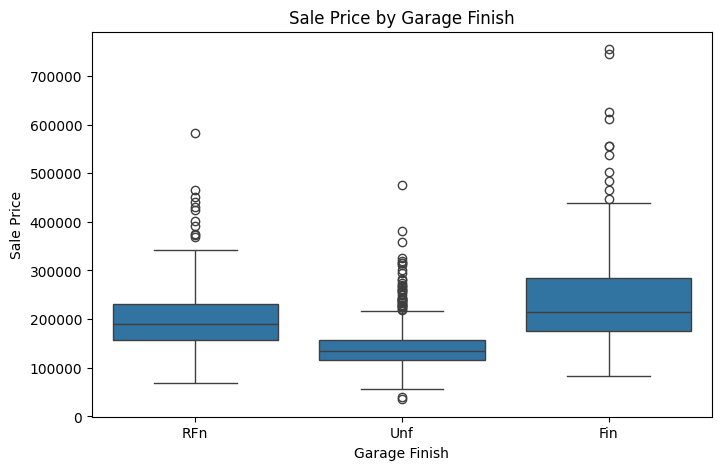

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='GarageFinish', y='SalePrice', data=df_cleaned)
plt.title('Sale Price by Garage Finish')
plt.xlabel('Garage Finish')
plt.ylabel('Sale Price')
plt.show()

**By the boxplot, i can tell that there was some outliers, but do they really affect the test?**
**We need to do the test with and without the outliers, to see the real effect (if there any).**

In [13]:
# Define bounds for outliers and Removing them.
Q1 = df_cleaned['SalePrice'].quantile(0.25)
Q3 = df_cleaned['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_cleaned[(df_cleaned['SalePrice'] >= lower_bound) & (df_cleaned['SalePrice'] <= upper_bound)]

## ANOVA test

**Since we are comparing the means of more than two groups (GarageFinish categories), the ANOVA test is appropriate here. This is a parametric test, assuming normality in the data, and it will be two-tailed, beacuse we are searching for any significant difference in means between groups (increasing or decreasing).**

**Hypotheses:**

**Null Hypothesis (H0): There is no significant difference in the mean SalePrice across the different categories of GarageFinish.**

**Alternative Hypothesis (H1): There is a significant difference in the mean SalePrice across the different categories of GarageFinish.**

In [14]:
# ANOVA test (including the outliers).
f_statistic, p_value = f_oneway(
    df_cleaned["SalePrice"][df_cleaned["GarageFinish"] == "Unf"],
    df_cleaned["SalePrice"][df_cleaned["GarageFinish"] == "RFn"],
    df_cleaned["SalePrice"][df_cleaned["GarageFinish"] == "Fin"])

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value:.7f}")

F-statistic: 250.96246721359347
p-value: 0.0000000


In [15]:
# ANOVA test (without the outliers)
f_statistic2, p_value2 = f_oneway(
    df_no_outliers["SalePrice"][df_no_outliers["GarageFinish"] == "Unf"],
    df_no_outliers["SalePrice"][df_no_outliers["GarageFinish"] == "RFn"],
    df_no_outliers["SalePrice"][df_no_outliers["GarageFinish"] == "Fin"])

print(f"F-statistic: {f_statistic2}")
print(f"p-value: {p_value2:.7f}")

F-statistic: 270.3725832235749
p-value: 0.0000000


**So as we can see, the outliers doesn't affect the data that much so no need to drop them.**

**the p-value from the ANOVA test is less than 0.05, so _the null hypothesis is rejected_, and as a conclusion there is a _statistically significant difference_ between the means of at least two groups.**

**Since the ANOVA test yielded a statistically significant result, i will run a post-hoc test (Tukey's HSD) To find out which specific groups differ.**

In [16]:
#Tukey's HSD post-hoc test
comp = mc.MultiComparison(df_cleaned['SalePrice'], df_cleaned['GarageFinish'])
tukey_result = comp.tukeyhsd()

print(tukey_result.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower        upper    reject
---------------------------------------------------------------
   Fin    RFn -37983.8207   0.0  -49448.4512 -26519.1901   True
   Fin    Unf -97896.2672   0.0 -108543.1897 -87249.3447   True
   RFn    Unf -59912.4465   0.0  -69985.6696 -49839.2235   True
---------------------------------------------------------------


**Visualization for the effect of the 'GarageFinish'**

C:\Users\mohdh\AppData\Local\Temp\ipykernel_7008\100999439.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='GarageFinish', y='SalePrice', data=df, estimator=np.mean, ci=None, color='#9600ff')


Text(0, 0.5, 'Average Sale Price')

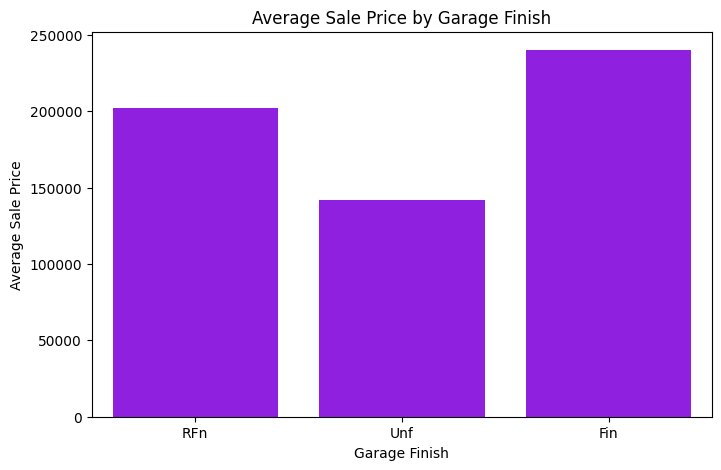

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(x='GarageFinish', y='SalePrice', data=df, estimator=np.mean, ci=None, color='#9600ff')
plt.title('Average Sale Price by Garage Finish')
plt.xlabel('Garage Finish')
plt.ylabel('Average Sale Price')

**Conclusion:**

**All the comparisons between the GarageFinish categories (Fin, RFn, Unf) show statistically significant differences in mean SalePrice. All of the p-values are 0, and the confidence intervals do not include 0, meaning that the difference in means is statistically significant**

**The Fin vs. Unf comparison shows the largest difference in average sale prices among the categories (97,896$), indicating that the type of garage finish has a substantial effect on the sale price**

**The Fin garage finish is associated with the highest average sale price among the categories (Fin, RFn, Unf).**

## Multiple linear regression model

**Choosing the best predictors for the linear regression model, requires a relevant predictors based on their relationships with SalePrice, so after checking the data source i took a glence for which categorical data is the most important, also i have used the correlation test to choose the best numerical features.**

In [18]:
columns_corr = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[columns_corr].corr()['SalePrice'].sort_values(ascending=False)
correlations

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

**So based on the correlation result, and after searching for the best Categorical Features, i will choose the following predectors:**

**Numerical Features: 'GarageCars', 'TotalBsmtSF'**

**Categorical Features: 'Neighborhood', 'Condition1', 'ExterQual', 'BsmtQual', 'KitchenQual', 'HeatingQC', 'SaleType', 'SaleCondition', 'RoofStyle', 'Exterior1st', 'Exterior2nd'**

**Note: Some of the Numerical Features has a higher correlation with the 'SalePrice', but choosing these Features led to a violation for the 'No Multicollinearity' assumption (after testing)**

## Visual representation for the effect of some predectors.

C:\Users\mohdh\AppData\Local\Temp\ipykernel_7008\2552057043.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Neighborhood', y='SalePrice', data=df, estimator=np.mean, ci=None, color='#9600ff')


Text(0, 0.5, 'Average Sale Price')

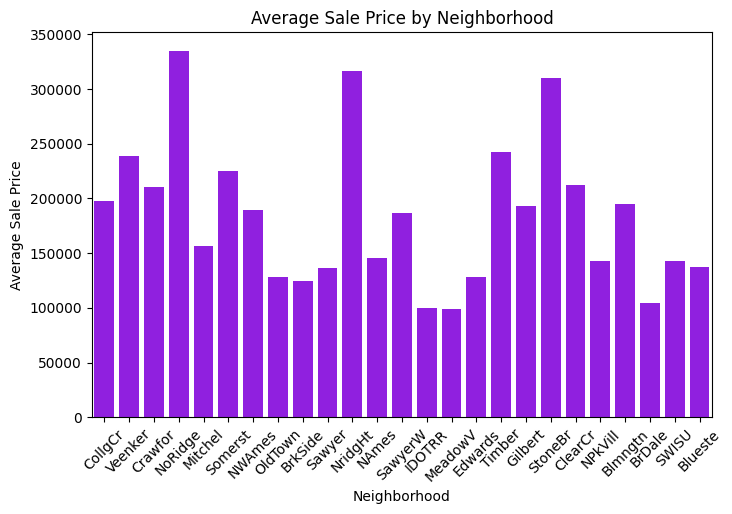

In [19]:
# Bar plot for average SalePrice by Neighborhood
plt.figure(figsize=(8, 5))
sns.barplot(x='Neighborhood', y='SalePrice', data=df, estimator=np.mean, ci=None, color='#9600ff')
plt.xticks(rotation=45)
plt.title('Average Sale Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Sale Price')

Text(0, 0.5, 'Sale Price')

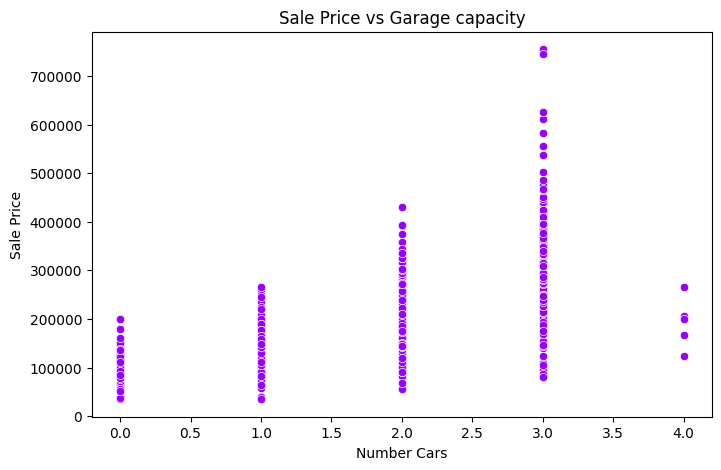

In [20]:
# Scatter plot for SalePrice vs Garage capacity
plt.figure(figsize=(8, 5))
sns.scatterplot(x='GarageCars', y='SalePrice', data=df, color='#9600ff')
plt.title('Sale Price vs Garage capacity')
plt.xlabel('Number Cars')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

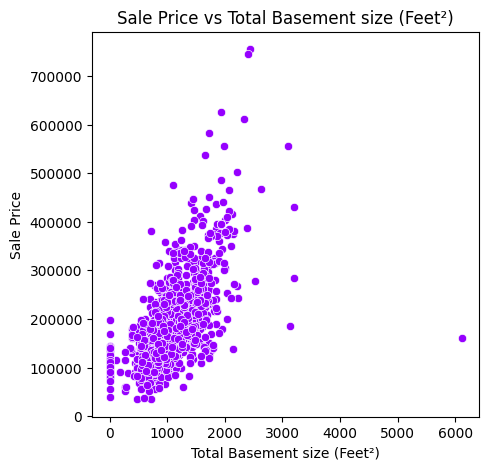

In [21]:
# Scatter plot for SalePrice vs Total Basement size
plt.figure(figsize=(5, 5))
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=df, color='#9600ff')
plt.title('Sale Price vs Total Basement size (Feet²)')
plt.xlabel('Total Basement size (Feet²)')
plt.ylabel('Sale Price')

## Model building

In [22]:
# For Numerical Featuers
num_df = df[['SalePrice', 'GarageCars', 'TotalBsmtSF']].dropna()
numerical_predictors = ['GarageCars', 'TotalBsmtSF']
X_numerical = num_df[['GarageCars', 'TotalBsmtSF']]  

In [23]:
# For Categorical Data
df2 = df[['Neighborhood', 'Condition1', 'ExterQual', 'BsmtQual', 'KitchenQual', 'HeatingQC', 'SaleType', 'SaleCondition', 'RoofStyle', 'Exterior1st', 'Exterior2nd']]
category_Predectors = pd.get_dummies(df2, drop_first=True).dropna() #One-Hot encoding
X_numerical = X_numerical.loc[category_Predectors.index]

In [24]:
# Combining the both of DataFrames
final_df = pd.concat([X_numerical, category_Predectors], axis=1)

In [25]:
X = final_df
y = num_df['SalePrice'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error (MAE): 24970.22
R-squared: 0.78


**Mean Absolute Error (MAE) 24970.22: This means that on average, the predicted sale prices deviate (lower deviation) from the actual sale prices by approximately 24k Dollars, This level of error may be acceptable depending on the high avarage sale price (185k Dollars), so based on Percentage Error Calculation the deviation value = 13.5% .**


**R-squared 0.78: The R-squared value of 0.78 signifies that approximately 78% of the variability in the sale prices can be explained by the features included in the model. This suggests a strong relationship between the predictors and the sale price.**

In [26]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

                       Coefficient
GarageCars            21321.974247
TotalBsmtSF              37.335069
Neighborhood_Blueste  14967.027160
Neighborhood_BrDale    5147.401544
Neighborhood_BrkSide  14136.751111
...                            ...
Exterior2nd_Other     35107.261094
Exterior2nd_Plywood   -9242.614890
Exterior2nd_Stone    -63747.433367
Exterior2nd_Stucco   -36338.218230
Exterior2nd_VinylSd   15711.505791

[94 rows x 1 columns]


**An overview for some of Coefficient meaning:**

**GarageCars (21321.974247): Each additional car capacity in the garage is associated with an increase in sale price of approximately 21k Dollars.**

**TotalBsmtSF: The coefficient of approximately 37.34 indicates that for each additional square foot of basement area, the sale price increases by about 37.34 Dollars**

## Model Assumptions check

### 1- Linear Relationship Between Input Features and Target Variable

**✔ Since all the correlation coefficients of the predictors are Strong/moderate, this indicates that Relationship Between Input Features and Target Variable are Linear, and here is a Scatter Plot for TotalBsmtSF (Total square feet of basement area) for example:**

Text(0, 0.5, 'SalePrice')

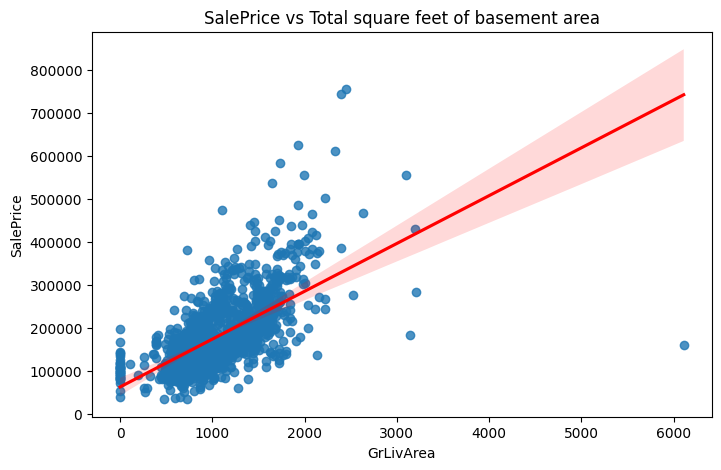

In [27]:
plt.figure(figsize=(8, 5))
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=num_df, line_kws={"color": "red"})
plt.title('SalePrice vs Total square feet of basement area')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

### 2- Normality of Variables

**✔ The following Histogram shows that the assumption is not violated, according to the normal Distribution.**

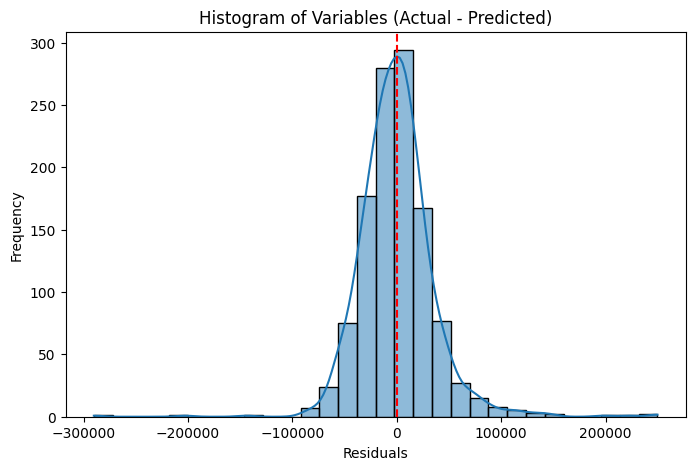

In [28]:
variables = y_train - y_train_pred
plt.figure(figsize=(8, 5))
sns.histplot(variables, bins=30, kde=True)
plt.title('Histogram of Variables (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')

### 3- No or Little Multicollinearity

In [29]:
num_df_no_target = num_df.drop(columns=['SalePrice'])
vif_data = pd.DataFrame()
vif_data['Feature'] = num_df_no_target.columns
vif_data['VIF'] = [variance_inflation_factor(num_df_no_target.values, i) for i in range(num_df_no_target.shape[1])]

print(vif_data)

       Feature       VIF
0   GarageCars  6.187433
1  TotalBsmtSF  6.187433


**The VIF values for the numerical values is < 10, so the assumption is not violated.** 

### 4- Homoscedasticity

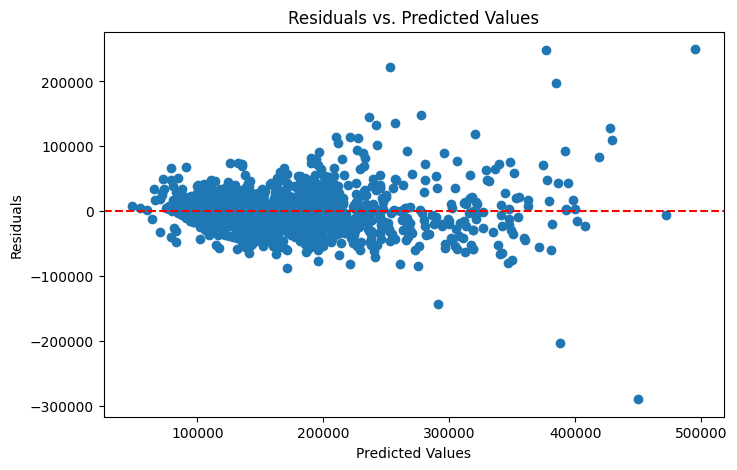

In [30]:
plt.figure(figsize=(8, 5))
plt.scatter(y_train_pred, variables)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

**The Residuals are randomly scattered around the red line, it indicates that Homoscedasticity is not violated**

## Model Conclusion

**Mean Absolute Error (MAE) of $24,970.22 and an R-squared value of 0.78. While the model explains a substantial portion of the variance in sale prices, To enhance model performance, more domain knowledge is essential. Understanding the real estate market can inform better feature selection, By incorporating insights from industry experts and additional relevant variables, the model can become more robust and provide more accurate predictions of house prices**